# Optimal Market Making Strategy

In this notebook, we will research the optimal market making strategy by using high frequency tick level data of BTCUSDT Perpetual 2023-may 31 on Binance.  
And more data can be downloaded from binance historical data.

In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import scienceplots
from scipy.optimize import minimize , basinhopping , curve_fit
from scipy.stats import poisson ,stats , norm , pareto
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.distributions.empirical_distribution import ECDF

## Data Preparation

In [43]:
header = ['trade_id','price','quantity','order_id','timestamp','is_buyer_maker']
df = pd.read_csv('./Data/BTCUSDT-trades-2023-05-31.csv',header=0 , names = header)
df.head()

,trade_id,price,quantity,order_id,timestamp,is_buyer_maker
0,3765419375,27680.0,0.400,11072.0000,1685491200110,True
1,3765419376,27680.0,0.006,166.0800,1685491200156,True
2,3765419377,27680.0,0.300,8304.0000,1685491200157,True
3,3765419378,27680.1,0.003,83.0403,1685491200244,False
4,3765419379,27680.1,0.003,83.0403,1685491203809,False


In [120]:
def closed_time_series(df, time_interval):
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.set_index('timestamp')
    df['quantity'] = df['quantity']
    df['buy_quantity'] = np.where(df['is_buyer_maker'], df['quantity'], 0)
    df['sell_quantity'] = np.where(df['is_buyer_maker'], 0, df['quantity'])
    df = df.resample(str(time_interval)+'S').agg({'price':'last', 'quantity':'sum', 'buy_quantity':'sum', 'sell_quantity':'sum'})
    df['return'] = df['price'].diff()
    df = df.dropna()
    return df

If terminal time $T$ is large, volatility is more stochastic. 

In [121]:
delta_t = 60 #seconds
data = closed_time_series(df,delta_t)[:100]
data.head()

,price,quantity,buy_quantity,sell_quantity,return
timestamp,,,,,
2023-05-31 00:01:00,27678.4,77.099,26.699,50.400,4.9
2023-05-31 00:02:00,27678.4,56.843,31.884,24.959,0.0
2023-05-31 00:03:00,27685.7,83.739,17.442,66.297,7.3
2023-05-31 00:04:00,27673.1,73.537,60.985,12.552,-12.6
2023-05-31 00:05:00,27670.5,99.029,81.576,17.453,-2.6


## Market Impact Model
Let the price impact is given by 
$$
\Delta p = p^Q - s 
$$
where $p^Q$ is highest limit order executed and $s$ is reference price.  

The price impact is related to the market order size $Q$ by Potters and Bouchaud (2003)

$$
\begin{align*}
\Delta p & \propto \ln(Q) \\
        &= K \ln(Q) + b
\end{align*}
$$
where K is market impact parameter.

But temporary market impact is hard to measure. Because of the sliced execution of market order.

In [122]:
def market_impact(df):
    qty = np.log(df['quantity'] * df['price'])
    K , b = np.polyfit(qty,df['return'],1)
    return K , b

split data to sell and buy

In [123]:
sell_data = data[data['return'] < 0]
buy_data = data[data['return'] > 0]

split train and test data

In [124]:
x_train_sell , x_test_sell , y_train_sell , y_test_sell = train_test_split(np.log(sell_data['quantity'] * sell_data['price']),np.abs(sell_data['return']),test_size=0.2,random_state=42)
x_train_buy , x_test_buy , y_train_buy , y_test_buy = train_test_split(np.log(buy_data['quantity'] * buy_data['price']),buy_data['return'],test_size=0.2,random_state=42)

Linear regression

In [125]:
sell_model = LinearRegression()
sell_model.fit(x_train_sell.values.reshape(-1,1),y_train_sell.values.reshape(-1,1))

buy_model = LinearRegression()
buy_model.fit(x_train_buy.values.reshape(-1,1),y_train_buy.values.reshape(-1,1))

print("sell model r2 score: ",sell_model.score(x_test_sell.values.reshape(-1,1),y_test_sell.values.reshape(-1,1)))
print("buy model r2 score: ",buy_model.score(x_test_buy.values.reshape(-1,1),y_test_buy.values.reshape(-1,1)))

print("K: ", sell_model.coef_[0][0], "b: ", sell_model.intercept_[0])
print("K: ", buy_model.coef_[0][0], "b: ", buy_model.intercept_[0])

sell model r2 score:  -3.066352023089065
buy model r2 score:  -0.476315935871664
K:  6.011672719508725 b:  -81.41616044364429
K:  4.44674036755739 b:  -58.474957679535514


In [127]:
mse = mean_squared_error(y_test_sell.values.reshape(-1,1),sell_model.predict(x_test_sell.values.reshape(-1,1)))
rmse = np.sqrt(mse)
print("MSE: ",mse)
print("RMSE: ", rmse)

MSE:  77.09602628269789
RMSE:  8.78043428781845


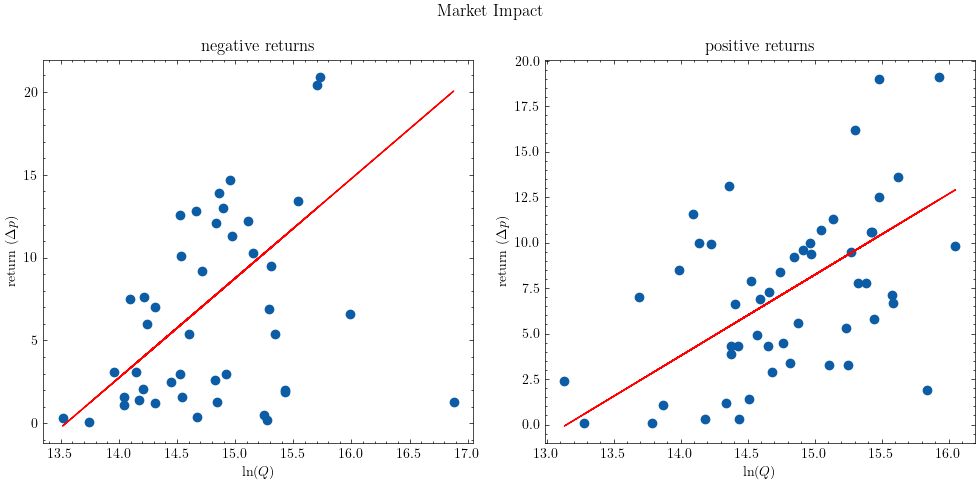

In [128]:
plt.figure(figsize=(10,5))
plt.style.use('science')
plt.suptitle('Market Impact')

plt.subplot(1,2,1)
plt.title('negative returns')
plt.scatter(np.log(sell_data['quantity'] * sell_data['price']),np.abs(sell_data['return']))
plt.plot(np.log(sell_data['quantity'] * sell_data['price']),sell_model.predict(np.log(sell_data['quantity'] * sell_data['price']).values.reshape(-1,1)),color='red',label='linear regression')
plt.xlabel(r'$\ln(Q)$')
plt.ylabel(r'return ($\Delta p$)')

plt.subplot(1,2,2)
plt.title('positive returns')
plt.scatter(np.log(buy_data['quantity'] * buy_data['price']),buy_data['return'])
plt.plot(np.log(buy_data['quantity'] * buy_data['price']),buy_model.predict(np.log(buy_data['quantity'] * buy_data['price']).values.reshape(-1,1)),color='red',label='linear regression')

plt.xlabel(r'$\ln(Q)$')
plt.ylabel(r'return ($\Delta p$)')

plt.tight_layout()
plt.show()

MSE and R2 is not good enough

## Market Order Distribution 
In the econophysics literture, the market order quantity is often assumed to follow a power law distribution.  
The power law distribution is defined as:  
$$ \mathbb {P(x)} \propto x^{-1 -\alpha}$$  
where $\alpha$ is the exponent of the power law distribution. But you have notice that the probability distribution function is not normalized.  
To normalize the distribution, we need to integrate the distribution function. The result is:  

$$ \mathbb {P(x)} = \frac{\alpha x_{\mathrm{m}}^\alpha}{x^{\alpha+1}}$$  
that is Pareto distribution.

The maximum likelihood estimator of $\alpha$ is: 
$$ \hat{\alpha} = 1 + \frac{n}{\sum_{i=1}^n \ln \frac{x_i}{x_{\mathrm{m}}}}$$

In [129]:
def maximum_likelihood_alpha(quantity,MIN_ORDER):
    N = len(quantity)
    log_mean = np.sum(np.log(quantity / MIN_ORDER))
    alpha_hat = N / log_mean
    return alpha_hat

In [130]:
alpha_hat_buy = maximum_likelihood_alpha(data['buy_quantity'],0.01)
print("alpha buy: ",alpha_hat_buy)

alpha_hat_sell = maximum_likelihood_alpha(data['sell_quantity'],0.01)
print("alpha sell: ",alpha_hat_sell)

alpha buy:  0.12167293019677625
alpha sell:  0.1195583938424116


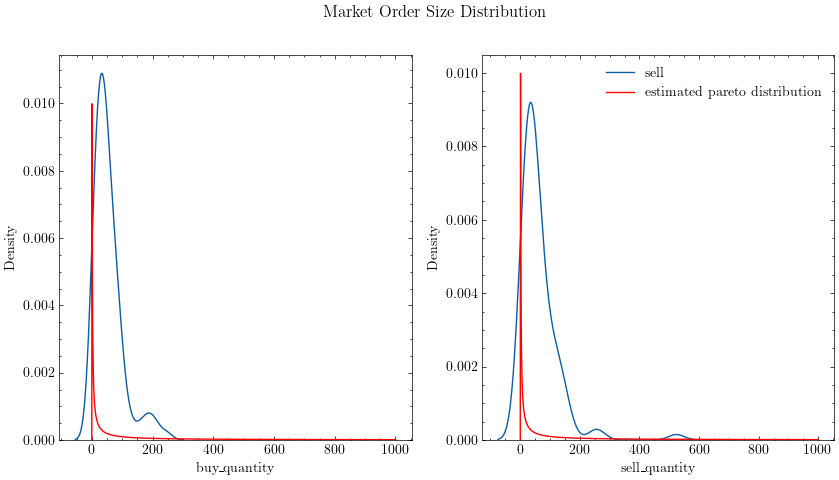

In [148]:
plt.figure(figsize=(10,5))
x = np.linspace(0,1000,1000)

plt.suptitle('Market Order Size Distribution')

plt.subplot(1,2,1)
sns.kdeplot(data['buy_quantity'],label='buy')
plt.plot(x,pareto.pdf(x,0.01),color='red',label='estimated pareto distribution')

plt.subplot(1,2,2)
sns.kdeplot(data['sell_quantity'],label='sell')
plt.plot(x,pareto.pdf(x,0.01),color='red',label='estimated pareto distribution')
plt.legend()
plt.show()

## Probability of Execution

Now we can calculate the probability of execution of market making agent's limit order(LO).   
Let us assume that LO is executed if mid-price moves over her LO. It can be expressed as:  $ \mathbb {P(\Delta r > \delta)}$   


Then using the market impact model, we can rewrite the probability of execution as:
$$\begin{aligned}
\lambda(\delta) & =\Lambda P(\Delta p>\delta) \\
& =\Lambda P(\ln (Q)>K \delta) \\
& =\Lambda P(Q>\exp (K \delta)) \\
& =\Lambda \alpha x_{min}^{\alpha}\int_{\exp (K \delta)}^{\infty} x^{-1-\alpha} \mathrm{d} x \\
& =A \exp (-k \delta)
\end{aligned} $$
where $A = \Lambda  x_{min}^{\alpha}$ and $k = \alpha  K$ and $\Lambda$ is market order frequency of buy or sell .



In [104]:
def market_order_frequency(data):
    all_market_order = data['quantity'].sum()/data['quantity'].mean()
    return all_market_order

def intensity_lambda(A,k,delta):
    return A * np.exp(- k * delta)

In [114]:
k = alpha_hat_buy * (sell_model.coef_[0][0])
A = market_order_frequency(data) * 0.01 ** alpha_hat_buy
delta = np.linspace(0,100,100)

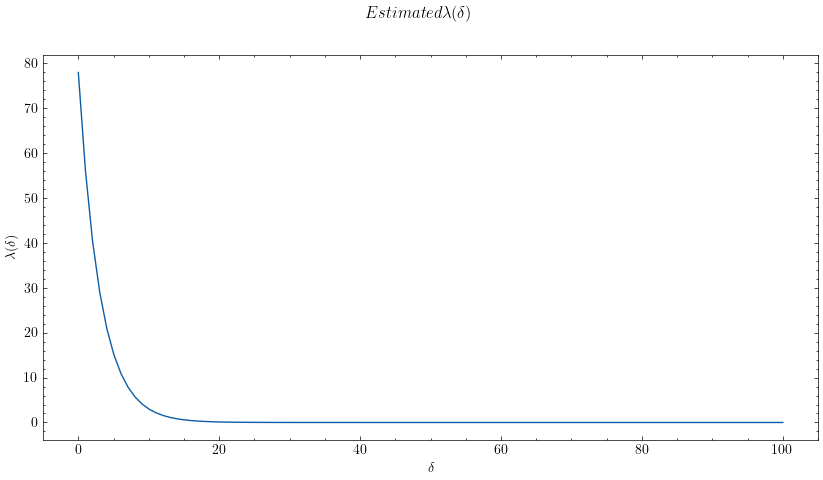

In [115]:
plt.figure(figsize=(10,5))
plt.suptitle(r'$Estimated \lambda(\delta)$')
plt.plot(delta,intensity_lambda(A,k,delta))
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\lambda(\delta)$')
plt.show()

## Empirical Method

In [15]:
def emprical_lambda_method_1(df,number_of_trials,max_tick_size,delta_t,tick_size):
    #row: number of trials , col: number of events
    timestamp = df['timestamp'].values
    price = df['price'].values
    event_list_p = np.zeros((number_of_trials,max_tick_size))
    event_list_m = np.zeros((number_of_trials,max_tick_size))
    for i in range(1,max_tick_size):
        for j in range(1,number_of_trials):
            time_index = random.randint(0, int(len(df)/2))
            init_time = timestamp[time_index]
            init_price = price[time_index]
            time_diff = 0
            event_count_p = 0
            while time_diff < delta_t * 1000:
                price_diff = (price[time_index] - init_price)/tick_size
                time_diff = timestamp[time_index] - init_time
                if price_diff > i:
                    event_count_p += 1
                    # break ## note
                else:
                    pass 
                time_index += 1
            event_list_p[j][i] = event_count_p
    for i in range(1,max_tick_size):
        for j in range(1,number_of_trials):
            time_index = random.randint(0, int(len(df)/2))
            init_time = timestamp[time_index]
            init_price = price[time_index]
            time_diff = 0
            event_count_m = 0
            while time_diff < delta_t * 1000:
                price_diff = (price[time_index] - init_price)/tick_size
                time_diff = timestamp[time_index] - init_time
                if price_diff < -i:
                    event_count_m += 1
                    # break
                else:
                    pass 
                time_index += 1
            event_list_m[j][i] = event_count_m
    mean_p = np.mean(event_list_p,axis=0)
    mean_m = np.mean(event_list_m,axis=0)
    return mean_p , mean_m

In [16]:
number_of_trials = 100
max_tick_size = 100
delta_t = 60
tick_size = 0.1

mean_p , mean_m = emprical_lambda_method_1(df,number_of_trials,max_tick_size,delta_t,tick_size)

## Fitting

In [154]:
def exponential_func(x, A, k):
    return A * np.exp(-k * x)

x = np.arange(0,max_tick_size)

popt_m, pcov = curve_fit(exponential_func, x, mean_m)
popt_p, pcov = curve_fit(exponential_func, x, mean_p)

print('A: ',popt_m[0], 'k: ', popt_m[1])

A:  4.325489220001155 k:  0.0984122521428575


/var/folders/tc/pk8_r5g56wx6w90jrt_973rc0000gn/T/ipykernel_24174/727832895.py:2: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-k * x)


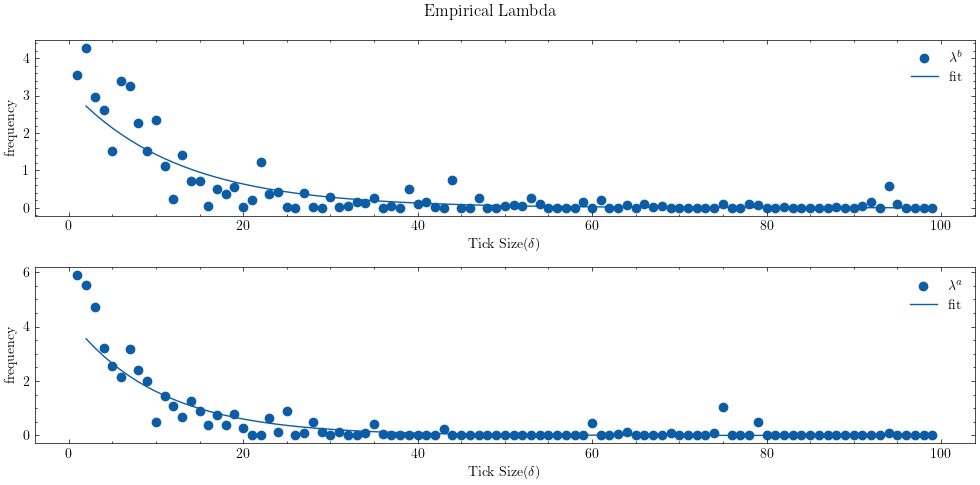

In [155]:
x = np.arange(1,max_tick_size)

plt.style.use('science')
plt.figure(figsize=(10,5))
plt.suptitle('Empirical Lambda')

plt.subplot(2,1,1)
plt.scatter(x,mean_p[1:],label=r'$\lambda^b$')
plt.plot(x[1:],exponential_func(x[1:],*popt_p),label='fit')
plt.ylabel('frequency')
plt.xlabel(r'Tick Size($\delta$)')
plt.legend()

plt.subplot(2,1,2)
plt.scatter(x,mean_m[1:],label=r'$\lambda^a$')
plt.plot(x[1:],exponential_func(x[1:],*popt_m),label='fit')
plt.ylabel('frequency')
plt.xlabel(r'Tick Size($\delta$)')
plt.legend()

plt.tight_layout()
plt.show()

## Arithmetic Brownian Motion

"Arithmetic Brownian motion is one of the most fundamental price models frequently used in High-Frequency Trading (HFT) research papers. Typically, to employ this model, the following assumptions are made:

The time step, dt, is very short.
The terminal time, T, is very short.
If T becomes longer, Arithmetic Brownian motion carries the risk of generating negative values.

Arithmetic Brownian motion follows the stochastic differential equation given as follows:
$$ 
dS_t = \mu dt + \sigma dW_t
$$
- $\mu$ is drift term
- $\sigma$ is variance term. in finance, it is volatility
- $W_t \sim \mathcal{N}(0,t)$ is Winner process.  

## The parameter estimation of arithmetic brownian motion 

The first momnet is, 
$$ 
\mathbb{E}[dS_t] = \mu dt 
$$

The second moment is, 
$$
Var[dS_t] = \sigma^2 * dt
$$

thus, we can estimate parameters easly.



In [156]:
def mu_hat(data):
    mu = data['return'].mean() 
    return mu

def sigma_hat(data):
    sigma = data['return'].std()
    return sigma

## Simulation with Euler-Maruyama method

$$
S_{t+\Delta t} = S_t + \mu S_t \Delta t + \sigma S_t \sqrt{\Delta t} Z
$$
where $Z \sim \mathcal{N}(0,1)$.  

And we can write this as,
$$
S_{t} = S_0 + \mu t + \sigma \sqrt{t} Z
$$


In [157]:
def arithmeticBM(S0, mu, sigma, T, N):
    dt = T / N
    t = np.linspace(0, T, N)
    epsilon = np.random.standard_normal(size=N)
    W = np.cumsum(epsilon * np.sqrt(dt))
    S = S0 + mu * t + sigma * W 
    return S

In [158]:
mu_h = mu_hat(data)
sigma_h = sigma_hat(data)
print(f"mu: {mu_h}", f"sigma: {sigma_h}")

mu: 0.8920000000000072 sigma: 8.297385252005974


In [161]:
S_0 = data['price'][0]
s = arithmeticBM(S_0, mu_h, sigma_h, 100, 100)

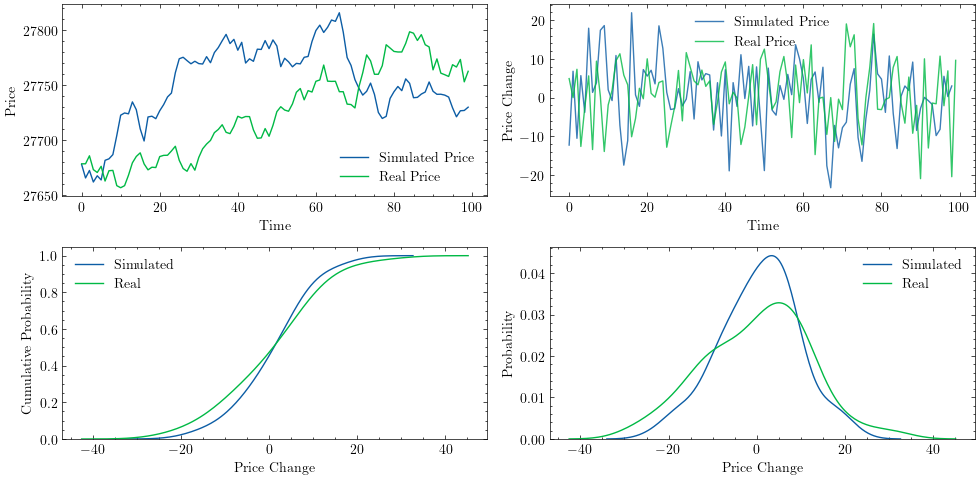

In [162]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(s, label='Simulated Price')
plt.plot(np.array(data['price']), label='Real Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(np.diff(s), label='Simulated Price',alpha=0.8)
plt.plot(np.array(data['return']), label='Real Price',alpha=0.8)
plt.xlabel('Time')
plt.ylabel('Price Change')
plt.legend()

plt.subplot(2, 2, 3)
sns.kdeplot(np.diff(s), label='Simulated',cumulative=True)
sns.kdeplot(np.diff(data['return']), label='Real',cumulative=True)
plt.xlabel('Price Change')
plt.ylabel('Cumulative Probability')
plt.legend()

plt.subplot(2, 2, 4)
sns.kdeplot(np.diff(s), label='Simulated')
sns.kdeplot(np.diff(data['return']), label='Real')
plt.xlabel('Price Change')
plt.ylabel('Probability')
plt.legend()
plt.tight_layout()

plt.show()

## Goodness of fit

We can use Kolmogorov-Smirnov test to check the goodness of fit.  
$$
H_0 : \text{The simulation is same with the real distribution} \\
H_1 : \text{The simulation is not same with the real distribution}
$$

p-value is less then 0.05, we can reject the null hypothesis.

In [163]:
stats.kstest(np.diff(s),np.array(data['return']),alternative='two-sided')

KstestResult(statistic=0.08373737373737374, pvalue=0.8368105682614753)

## Jump diffusion 

In real world, the distribution of log return is not really normal.   
It is more likely to have a fat tail.  

Brownian Motion with jump diffusion follows SDE below:  
$$dS_t = \mu dt + \sigma dW_t + \xi dN_{t}^a - \xi dN_{t}^b$$   
where $\xi \gt 0$ and $dN_{t}^a$ is the number of jumps that occur in the interval $(t, t+dt)$.  
The jump size can be interpreted as adverse selection.

Let's solve the closed form solution of jump diffusion.  
In this paper, we assume that the jump size is constant. Let us apply Euler's discrete method to the SDE, we get:
$$ S_t = S_0 + \mu t + \sigma W_t + \sum_{i=0}^{N_t^a} \xi_i - \sum_{i=0}^{N_t^b} \xi_i $$ 

where $\xi_i$ is the jump size at time $t_i$ and $N_t$ is the number of jumps that occur in the interval $(0, t)$.    

Since we know number of jumps $N_t$ follows a Poisson distribution, we can get the distribution of $S_t$.  
If $X_t = S_t - S_0$, then by the law of the total probability, we have  
$$ \mathbb{P}(X_t = x) = \sum_{i,j = 0}^{\infin} \mathbb{P}(X_t = x | N_t^a = i , N_t^b = j) \mathbb{P}(N_t^a = i) \mathbb{P}(N_t^b = j) $$

In [164]:
def ABDJ(S0, mu, sigma,jump_intensity_ask,jump_intensity_bid,jump_size_ask, jump_size_bid ,T, N):
    dt = T / N
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size=N)
    W = np.cumsum(W) * np.sqrt(dt)
    J_ask = np.random.poisson(jump_intensity_ask, size=N)
    J_bid = np.random.poisson(jump_intensity_bid, size=N)
    X = mu * t + sigma * W + np.cumsum(J_ask * jump_size_ask) - np.cumsum(J_bid * jump_size_bid)
    S = S0 + X
    return S

The Likelihood function of the jump diffusion is given by:

$$ \mathcal{L}(\mu, \sigma, \xi^a,\xi^b) = \prod_{t=1}^{N} \sum_{i,j=0}^{\infin} \mathbb{P}(X_t = x_t | N_t^a = i , N_t^b = j) \mathbb{P}(N_t^a = i) \mathbb{P}(N_t^b = j) $$

Log likelihood function is given by:

$$ 
\begin{align*}
\mathcal{l}(\mu, \sigma, \xi^a,\xi^b) &= \sum_{t=1}^{N} \ln \sum_{i,j=0}^{\infin} \mathbb{P}(X_t = x_t | N_t^a = i , N_t^b = j) \mathbb{P}(N_t^a = i) \mathbb{P}(N_t^b = j) \\
&= \sum_{t=1}^{N} \ln (\sum_{i,j=0}^{\infin}\frac{1}{\sqrt{2 \pi \sigma^2 t}} \exp{(-\frac{(x - (\mu t + i \xi^a - j \xi^b))^2}{2\sigma^2 t})} \frac{\exp{(-\lambda ^a t)} (\lambda^a t)^{i} }{i!} \frac{\exp{(-\lambda ^b t)}(\lambda^b t)^{j}}{j!})
\end{align*}
$$

where $ x_t$ is the observed mid-price at time $t_i$ and $N$ is the number of observations.  

- $Var[X_t | N_t^a = i , N_t^b = j] = \sigma^2 t$
- $E[X_t | N_t^a = i , N_t^b = j] = \mu t + i \xi^a + j \xi^b$


Since we know hidden variable. We don't need to EM algorithm we can use MLE method. But MLE method can found local minima. So we need to use MCMC or MAP method.

In [165]:
def mle_jump_diffusion(param, data , jump_intensity_ask,jump_intensity_bid):
    mu = param[0]
    volatility = param[1]
    jump_size_ask = param[2]
    jump_size_bid = param[3]

    likelihood = []
    for t in range(1, len(data)):
        sum_i = 0
        for i in range(1, 10):
            sum_j = 0
            for j in range(1, 10):
                sum_j += (np.exp(- jump_intensity_ask *t) * (jump_intensity_ask *t) ** i / np.math.factorial(i)
                    * np.exp(- jump_intensity_bid *t) * (jump_intensity_bid *t) ** j / np.math.factorial(j)
                    * (1 / np.sqrt(2 * np.pi * (volatility ** 2 * t)))
                    * np.exp(- (data[t] - mu * t - i * jump_size_ask + j * jump_size_bid) ** 2 / (2 * (volatility ** 2 * t))))
            sum_i += sum_j
        if sum_i == 0:
            likelihood.append(1e-100)
        else:
            likelihood.append(sum_i)
    log_likelihood = np.sum(np.log(likelihood))
    return -log_likelihood

def mle_jump_diffusion_vec(param, data, jump_intensity_ask, jump_intensity_bid):
    mu, volatility, jump_size_ask, jump_size_bid = param

    t = np.arange(1, len(data))
    i = np.arange(1, 10)
    j = np.arange(1, 10)

    T, I, J = np.meshgrid(t, i, j, indexing='ij')

    exp1 = np.exp(-jump_intensity_ask * T) * ((jump_intensity_ask * T) ** I) / np.vectorize(np.math.factorial)(I)
    exp2 = np.exp(-jump_intensity_bid * T) * ((jump_intensity_bid * T) ** J) / np.vectorize(np.math.factorial)(J)
    exp3 = (1 / np.sqrt(2 * np.pi * (volatility ** 2 * T))) \
           * np.exp(- ((data[T] - mu * T - I * jump_size_ask + J * jump_size_bid) ** 2) / (2 * (volatility ** 2 * T)))
    likelihood = np.sum(exp1 * exp2 * exp3, axis=(1, 2))

    likelihood[likelihood < 1e-100] = 1e-100

    log_likelihood = np.sum(np.log(likelihood))

    return -log_likelihood

In [174]:
#initial guess
mu_0 = mu_h
sigma_0 = sigma_h
jump_size_ask_0 = 0.1
jump_size_bid_0 = 0.1

#estimated jump intensity
jump_intensity_ask = 3
jump_intensity_bid = 3

args = (np.array(data['return']) , jump_intensity_ask , jump_intensity_bid)

param = [mu_0,sigma_0,jump_size_ask_0,jump_size_bid_0]
bounds = ((-np.inf,np.inf),(0.01,np.inf),(0.01,np.inf),(0.01,np.inf))
res_lbfgsb = minimize(mle_jump_diffusion_vec, param, args = args,bounds=bounds,method='L-BFGS-B')

print('l-bfgs-b',res_lbfgsb.x)

l-bfgs-b [-0.06414851  1.10224386  5.42123732  5.12102369]


Initial value is important.

In [175]:
res = res_lbfgsb

mu_hat = res.x[0]
sigma_hat = res.x[1]
jump_size_ask_hat = res.x[2]
jump_size_bid_hat = res.x[3]

path = ABDJ(data['price'][0],mu_hat,sigma_hat,jump_intensity_ask,jump_intensity_bid,jump_size_ask_hat,jump_size_bid_hat,100,100)

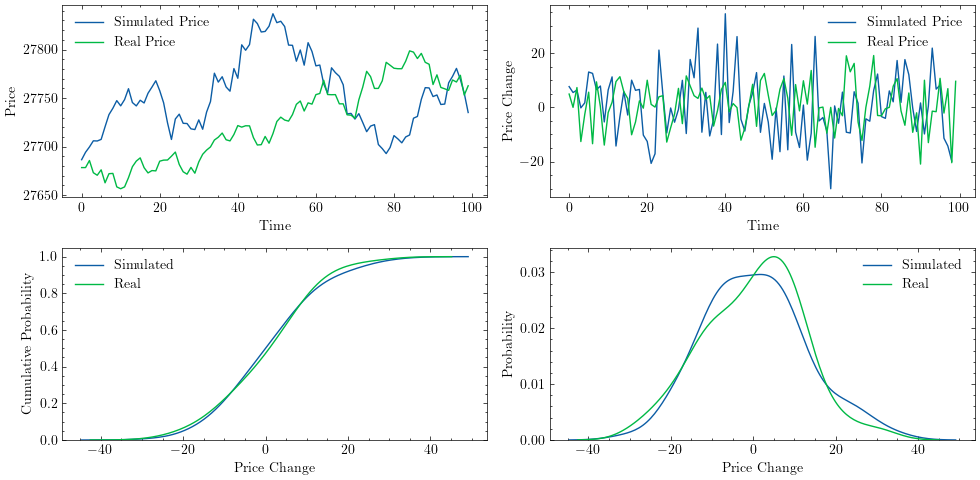

In [176]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(path, label='Simulated Price')
plt.plot(np.array(data['price']), label='Real Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(np.diff(path), label='Simulated Price')
plt.plot(np.array(data['return']), label='Real Price')
plt.xlabel('Time')
plt.ylabel('Price Change')
plt.legend()

plt.subplot(2, 2, 3)
sns.kdeplot(np.diff(path), label='Simulated',cumulative=True)
sns.kdeplot(np.diff(data['return']), label='Real',cumulative=True)
plt.xlabel('Price Change')
plt.ylabel('Cumulative Probability')
plt.legend()

plt.subplot(2, 2, 4)
sns.kdeplot(np.diff(path),label='Simulated')
sns.kdeplot(np.diff(data['return']),label='Real')
plt.xlabel('Price Change')
plt.ylabel('Probability')
plt.legend()

plt.tight_layout()

plt.show()

## Goodness of fit

In [177]:
stats.ks_2samp(np.array(data['return']),np.diff(path),alternative='two-sided')

KstestResult(statistic=0.20434343434343435, pvalue=0.027734839559171554)

## Optimal Market Making Strategy

The inventory of the market maker is the difference between the number of buy orders and the number of sell orders. i.e ) 
$$q_t = N_t^b - N_t^a$$  
where $N_t^{a}$ and $N_t^{b}$ are point processes.

Since our model is dimensionless ABM. Thus, cash process is given by the following equation:  
$$d X_t=S_t \left(1 + \delta_t^a \right ) dN_t^a- S_t \left(1- \delta_t^b \right)d N_t^b$$   

Our goal is to find the maximize objective function below: 
$$\sup _{\left(\delta_t^a\right)_t,\left(\delta_t^b\right)_t \in \mathcal{A}} \mathbb{E}\left[-\exp \left(-\gamma\left(X_T+q_T S_T\right)\right)\right]$$
where $\gamma$ is the risk aversion parameter in CARA utility function , $\mathcal{A}$ is set of predictable processes bounded from below,.




## HJB Equation

The HJB equation is given by the following equation:

$$ \partial t U + sup(\mathcal{L} U + F) = 0$$
where $\mathcal{L}$ is the infinitesimal generator of the process and $F$ is the running cost function.

The infinitesimal generator of the process is given by the following equation:
$$\mathcal{L} U = \frac{1}{2} \sigma^2 \partial_{s s}^2 U + \sup _{\delta^b} \lambda^b\left(\delta^b\right)\left[U\left(t, x-s+\delta^b, q+1, s\right)-U(t, x, q, s)\right] + \sup _{\delta^a} \lambda^a\left(\delta^a\right)\left[U\left(t, x+s+\delta^a, q-1, s\right)-U(t, x, q, s)\right]$$
where $\lambda^b$ and $\lambda^a$ are the intensity of the point process of buy and sell orders.

For $|q|<Q$ :
$$
\begin{gathered}
\partial_t u(t, x, q, s)+\frac{1}{2} \sigma^2 \partial_{s s}^2 u(t, x, q, s) \\
+\sup _{\delta^b} \lambda^b\left(\delta^b\right)\left[u\left(t, x-s+\delta^b, q+1, s\right)-u(t, x, q, s)\right] \\
+\sup _{\delta^a} \lambda^a\left(\delta^a\right)\left[u\left(t, x+s+\delta^a, q-1, s\right)-u(t, x, q, s)\right]=0
\end{gathered}
$$
For $q=Q$ :
$$
\begin{gathered}
\partial_t u(t, x, Q, s)+\frac{1}{2} \sigma^2 \partial_{s s}^2 u(t, x, Q, s) \\
+\sup _{\delta^a} \lambda^a\left(\delta^a\right)\left[u\left(t, x+s+\delta^a, Q-1, s\right)-u(t, x, Q, s)\right]=0
\end{gathered}
$$
For $q=-Q$ :
$$
\begin{gathered}
\partial_t u(t, x,-Q, s)+\frac{1}{2} \sigma^2 \partial_{s s}^2 u(t, x,-Q, s) \\
+\sup _{\delta^b} \lambda^b\left(\delta^b\right)\left[u\left(t, x-s+\delta^b,-Q+1, s\right)-u(t, x,-Q, s)\right]=0
\end{gathered}
$$
with the final condition:
$$
\forall q \in\{-Q, \ldots, Q\}, \quad u(T, x, q, s)=-\exp (-\gamma(x+q s))
$$

the solution of the HJB equation is given by the following equation:
$$ u(t, x, q, s)=\mathbb{E}\left[-\exp \left(-\gamma\left(X_T+q_T S_T\right)\right) | X_t=x, q_t=q, S_t=s\right]$$

In [152]:
def create_matrix(Q, k, gamma, sigma, A, T, t):
    alpha = k/2 * gamma * sigma**2
    eta = A * (1 + gamma/k)**(-1 - k/gamma)
    diag = [alpha * q**2 for q in range(-Q, Q+1)]
    off_diag = [eta] * (2*Q)
    a = np.diag(diag, k=0)
    l = np.diag(off_diag, k=1)
    k = np.diag(off_diag, k=-1)
    M = a + l + k
    return np.exp(-M*(T-t))


def calculate_v(Q, k, gamma, sigma, A, T, t):
    vec = np.ones(2*Q+1).T
    M = create_matrix(Q, k, gamma, sigma, A, T, t)
    v = np.dot(M, vec)
    return v 


def calculate_delta_star(Q, k, gamma, sigma, A, T):
    delta_b_star = []
    delta_a_star = []
    for t in np.arange(0, T):
        v = calculate_v(Q, k, gamma, sigma, A, T, t)
        delta_b_star.append([np.log(v[q]/v[q+1])/k + np.log(1+gamma/k)/gamma for q in range(0, 2*Q -1)])
        delta_a_star.append([np.log(v[q]/v[q-1])/k + np.log(1+gamma/k)/gamma for q in range(1, 2*Q)])
    return np.array(delta_b_star), np.array(delta_a_star)

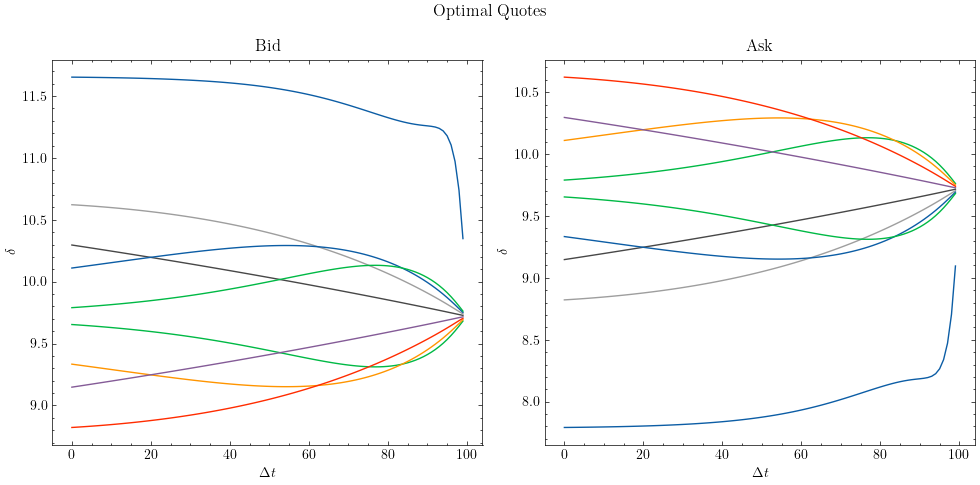

In [187]:
Q = 5
MIN_ORDER = 0.001
gamma = 0.1
A = alpha_hat_buy * (MIN_ORDER**alpha_hat_buy) * market_order_frequency(data)/2
k = alpha_hat_buy * (1)/2
T = 100
t = 0.0

delta_b_star, delta_a_star = calculate_delta_star(Q, k, gamma, sigma_hat, A, T)

plt.figure(figsize=(10, 5))
plt.suptitle('Optimal Quotes')
plt.subplot(1, 2, 1)
plt.title('Bid')
plt.plot(delta_b_star)
plt.ylabel(r'$\delta$')
plt.xlabel(r'$\Delta t$')

plt.subplot(1, 2, 2)
plt.title('Ask')
plt.plot(delta_a_star)
plt.ylabel(r'$\delta$')
plt.xlabel(r'$\Delta t$')
plt.tight_layout()
# plt.legend()
plt.show()